In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import math

from utils.function_utils import polynomial, taylor_expand_2d, polynomial_multiply, polynomial_sum, polynomial_power, print_polynomial, build_powers
from utils.function_utils import integrate_taylor_polynomial, derivative_t_polynomial, derivative_alpha_polynomial, taylor_expand_2d, matching_coeffs

from utils.distribution_utils import construct_pdf, construct_cdf

# Plot
import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot


# Part 0: Problem Definition

In this part, I define the FO calculation to match to

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


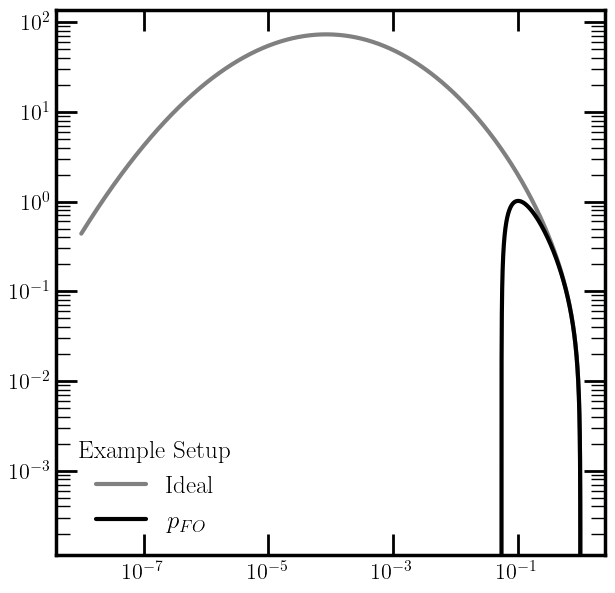

In [2]:
# Problem-dependent functions 
def t_from_x(x):
    return jnp.log(1/x)

def x_from_t(t):
    return jnp.exp(-t)


def p_ideal(t, alpha, params):
    alpha_bar = alpha #* 4/3 / jnp.pi
    return jnp.exp(-0.5 * alpha_bar * t**2) * alpha_bar * t


# Taylor expansion of p(t| alpha) = exp(-alpha * t**2)(alpha * t)
def p_t(t, alpha, params):
    alpha_bar = alpha #* 4/3 / jnp.pi
    return alpha_bar * t -  1 * alpha_bar**2 * t**3

p_x_ideal = lambda x, alpha, params: p_ideal(t_from_x(x), alpha, params) * jnp.abs(1/x)
p_x = lambda x, alpha, params: p_t(t_from_x(x), alpha, params) * jnp.abs(1/x)

def p_x(x, alpha, params):
    return p_t(t_from_x(x), alpha, params) * jnp.abs(1/x)


# Plot
xs = jnp.logspace(-8, 0, 10000)

fig, ax = newplot("full")
ax.plot(xs, p_x_ideal(xs, 0.118, None), label="Ideal", color = "grey")
ax.plot(xs, p_x(xs, 0.118, None), label=r"$p_{FO}$", color = "black")

ax.set_xscale("log")
ax.set_yscale("log")

plt.legend(title = "Example Setup")





# Part 1: Determine $c_{mn}$

This is the matching procedure. Given the FO calculation, these are the $c_{mn}$ we need to match to.

This is identical to what we were doing before. If we were using the c's directly, we would be done here. However, using complex polynomials, we later need to make sure our polynomial conspires to give us these c's.

In [ ]:

FIXED_MN = (2, 4)           # The coefficients of the distribution we cannot change
INITIALIZED_MN = (2, 4)     # The coefficients of the distribution we initialize the optimization with. Must be >= FIXED_MN
MODEL_MN = (4, 4)           # The coefficients of the model we are optimizing. Must be >= INITIALIZED_MN.


frozen_mask = jnp.zeros((MODEL_MN[0] + 1, MODEL_MN[1] + 1), dtype=bool)
frozen_mask = frozen_mask.at[:FIXED_MN[0] + 1, :FIXED_MN[1] + 1].set(True)


model_params = jnp.zeros((MODEL_MN[0] + 1, MODEL_MN[1] + 1))

matched_coeffs = matching_coeffs(p_t, INITIALIZED_MN[0], INITIALIZED_MN[1])
matched_coeffs = matched_coeffs[:INITIALIZED_MN[0] + 1, :INITIALIZED_MN[1] + 1]
model_params = model_params.at[:INITIALIZED_MN[0] + 1, :INITIALIZED_MN[1] + 1].set(matched_coeffs)

# Complex Polynomials

Helper functions: The first function takes an array of complex roots, and returns the coefficients of the polynomial with those roots. The second function takes the coefficients of a polynomial and returns the roots.

In [18]:
# roots_params is an (M+1) x N array of complex numbers
# N is the number of roots, each root is a polynomial of degree M in alpha
def polynomial_coeffs_from_roots(roots):

    M, N = roots.shape

    # Construct the polynomial
    poly = jnp.array([[1.0,]], dtype=roots.dtype)
    for i in range(N):



        # Make the monomonial (t - roots[0, i] - roots[1, i]*alpha - ... - roots[M, i]*alpha**M)
        # 2D array of shape (M+1, 1)

        monomial = jnp.zeros((M, 2), dtype=roots.dtype)
        monomial = monomial.at[0, 1].set(1.0)
        monomial = monomial.at[:, 0].set(-roots[:, i])


        poly = polynomial_multiply(poly, monomial)

    return poly


def root_polynomial(t, alpha, root_params):

    coeffs = polynomial_coeffs_from_roots(root_params)
    return polynomial(t, coeffs)




# Test function: roots corresponding to 1 + 2 alpha t + t^2, where I got these numbers by taylor expanding the roots in alpha
# The actual value of the roots are alpha +- sqrt(alpha^2 - 1)
# Note that the polynomial coeffs match up to the order in alpha! 
roots = jnp.array([[-0.0 - 1.0j, +-0.0 + 1.0j], 
                   [-1.0, -1.0], 
                   [0.5j, -0.5j],
                   [0.0, 0.0,],
                   [0.125j, -0.125j],
                   [0.0, 0.0],
                   [0.0625j, -0.0625j],
                   ])


poly = polynomial_coeffs_from_roots(roots)
print_polynomial(poly)


# print(collapse_2d_coeffs(1.0, poly))

# print(roots_from_params(1.0, poly))

# print(polynomial(roots_from_params(2.0, poly)[0], 1.0, poly))


c_0,0 = 1.00e+00+0.00e+00j c_0,1 = 0.00e+00+0.00e+00j c_0,2 = 1.00e+00+0.00e+00j 
c_1,0 = 0.00e+00+0.00e+00j c_1,1 = 2.00e+00+0.00e+00j c_1,2 = 0.00e+00+0.00e+00j 
c_2,0 = 0.00e+00+0.00e+00j c_2,1 = 0.00e+00+0.00e+00j c_2,2 = 0.00e+00+0.00e+00j 
c_3,0 = 0.00e+00+0.00e+00j c_3,1 = 0.00e+00+0.00e+00j c_3,2 = 0.00e+00+0.00e+00j 
c_4,0 = 0.00e+00+0.00e+00j c_4,1 = 0.00e+00+0.00e+00j c_4,2 = 0.00e+00+0.00e+00j 
c_5,0 = 0.00e+00+0.00e+00j c_5,1 = 0.00e+00+0.00e+00j c_5,2 = 0.00e+00+0.00e+00j 
c_6,0 = 0.00e+00+0.00e+00j c_6,1 = 0.00e+00+0.00e+00j c_6,2 = 0.00e+00+0.00e+00j 
c_7,0 = 0.00e+00+0.00e+00j c_7,1 = 0.00e+00+0.00e+00j c_7,2 = 0.00e+00+0.00e+00j 
c_8,0 = 7.81e-02+0.00e+00j c_8,1 = 0.00e+00+0.00e+00j c_8,2 = 0.00e+00+0.00e+00j 
c_9,0 = 0.00e+00+0.00e+00j c_9,1 = 0.00e+00+0.00e+00j c_9,2 = 0.00e+00+0.00e+00j 
c_10,0 = 1.56e-02+0.00e+00j c_10,1 = 0.00e+00+0.00e+00j c_10,2 = 0.00e+00+0.00e+00j 
c_11,0 = 0.00e+00+0.00e+00j c_11,1 = 0.00e+00+0.00e+00j c_11,2 = 0.00e+00+0.00e+00j 
c_12,0 = 3

# Part 2: Ansatz

The ansatz is:

$ f'(t, \alpha) = \kappa(\alpha) t^{Q} \times \prod_k^K (t - a_k(\alpha)) \times \prod_l^L |(t - z_l(\alpha))|^2$

where $a_k$ are real roots, $a_k = \sum_m^M a_{mk} \alpha^m$ and $z_l$ are complex roots, $z_l = \sum_m^M z_{lm} \alpha^m$.

Term 0 is the leading coefficient $\kappa$. This is parameterized by $\kappa = \sum_m^M \kappa_m \alpha^m$. This must be positive.

Term 1 is the number of `zero roots`. These are completely fixed. The number of zero roots is $Q$. The number Q is determined by looking at the coefficient matrix (`find_max_n`) and the lowest power of `t` determines Q. 

Term 3 is the number of `complex roots`. Note we only need to specify half of them. The number of complex roots is $2L$. The number $L$ is a choice, as long as $N - Q >= 2L$. 

Term 2 is the number of `real roots`. The number of real roots is $K$. The number of real roots is fixed by already knowing N, Q, and L.



In [ ]:




# t-derivative of matched coefficients
t_derivative = derivative_t_polynomial(matched_coeffs)
print_polynomial(t_derivative)

# determine the minimum n such that c_mn is not zero for all m
def find_max_n(coeffs):
    for n in range(coeffs.shape[1]):
        if jnp.any(coeffs[:, n] > 0):
            print(n)
            return n 
    return -1

print(find_max_n(t_derivative))

# print(roots_from_params(5.0, t_derivative))


def fprime_coeffs(params, num_zeros, M, N ):

    # Unpack the parameters
    leading_term = params["Leading"]
    half_complex_roots = params["Complex Roots"]
    real_roots = params["Real Roots"]

    # Get the complex conjugates
    half_complex_conjugates = jnp.conj(half_complex_roots)
    complex_roots = jnp.concatenate([half_complex_roots, half_complex_conjugates], axis=1)
    
    # Construct the polynomial
    complex_poly = polynomial_coeffs_from_roots(complex_roots)
    real_poly = polynomial_coeffs_from_roots(real_roots)
    zeros = jnp.zeros((1, num_zeros+1), dtype=complex_roots.dtype).at[0, num_zeros].set(1.0)

    poly = polynomial_multiply(polynomial_multiply(leading_term, complex_poly), real_poly)
    poly = polynomial_multiply(poly, zeros)

    return poly.real[:M+1, :N+1]

params = {}
params["Leading"] = jnp.array([[1.0,],])
params["Complex Roots"] = jnp.array([[-0.0 - 1.0j,], 
                   [-1.0], 
                   [0.5j],
                #    [0.0],
                #    [0.125j],
                #    [0.0],
                #    [0.0625j],
                   ])    
params["Real Roots"] = jnp.array([[],])
fprime_coeffs(params, 0, 2, 4)




/home/rikab/Documents/Research/NNEFT/jax/utils/function_utils.py:138: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  c = jnp.zeros((M+1, N+1), dtype=jnp.float64)


c_0,0 = 0.00e+00 c_0,1 = 0.00e+00 c_0,2 = 0.00e+00 c_0,3 = 0.00e+00 c_0,4 = 0.00e+00 
c_1,0 = 0.00e+00 c_1,1 = 0.00e+00 c_1,2 = 5.00e-01 c_1,3 = 0.00e+00 c_1,4 = 0.00e+00 
c_2,0 = 0.00e+00 c_2,1 = 0.00e+00 c_2,2 = 0.00e+00 c_2,3 = 0.00e+00 c_2,4 = -1.25e-01 
c_3,0 = 0.00e+00 c_3,1 = 0.00e+00 c_3,2 = 0.00e+00 c_3,3 = 0.00e+00 c_3,4 = 0.00e+00 
c_4,0 = 0.00e+00 c_4,1 = 0.00e+00 c_4,2 = 0.00e+00 c_4,3 = 0.00e+00 c_4,4 = 0.00e+00 
c_0,0 = 0.00e+00 c_0,1 = 0.00e+00 c_0,2 = 0.00e+00 c_0,3 = 0.00e+00 
c_1,0 = 0.00e+00 c_1,1 = 1.00e+00 c_1,2 = 0.00e+00 c_1,3 = 0.00e+00 
c_2,0 = 0.00e+00 c_2,1 = 0.00e+00 c_2,2 = 0.00e+00 c_2,3 = -5.00e-01 
1
1


Array([[1., 0., 1.],
       [0., 2., 0.],
       [0., 0., 0.]], dtype=float32)

# Part 3: MSE-Matching

It is numerically hard to get the roots $z$ to give us the polynomial with the $c_{mn}$ we want. Instead, we will try to use MSE to match the $c_{mn}$ directly.

In [15]:
import optax


def MSE_coeffs(ideal_coeffs, params, M_match, N_match, M_model, N_model , num_zeros):

    model_coeffs = fprime_coeffs(params, num_zeros, M_model, N_model)

    L2 = ((ideal_coeffs[:M_match+1, :N_match] - model_coeffs[:M_match+1, :N_match])**2).mean()
    L1 = jnp.abs(ideal_coeffs[:M_match+1, :N_match] - model_coeffs[:M_match+1, :N_match]).mean()
    return L2
    # No +1 on N since its a pdf, not a cdf


grad_MSE_coeffs = jax.grad(MSE_coeffs, argnums=1)

def MSE_match(p_t_ideal, M_match, N_match, M_model, N_model, seed = 0):


    # Hyperparameters
    learning_rate = 1e-2
    epochs = 5000
    loss_history = []
    params_history = []

    # Match the coefficients of the ideal distribution
    matched_coeffs_cdf = matching_coeffs(p_t_ideal, M_match, N_match)
    matched_coeffs_pdf = derivative_t_polynomial(matched_coeffs_cdf)

    num_zeros = find_max_n(matched_coeffs_pdf)
    num_complex_roots = (N_model - num_zeros) // 2
    num_real_roots = N_model - num_zeros - 2*num_complex_roots

    key = jax.random.PRNGKey(seed)
    real_key, complex_key = jax.random.split(key)

    # Initialize
    params = {}
    params["Leading"] = jnp.zeros((M_model+1,1)).at[1,0].set(1.0)
    params["Complex Roots"] = 0.0*jax.random.normal(complex_key, (M_model+1, num_complex_roots)) + 1j*jax.random.normal(complex_key, (M_model+1, num_complex_roots))
    params["Real Roots"] = -1 * 0.0 * jnp.abs(jax.random.normal(real_key, (M_model+1, num_real_roots)))


    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)

    for epoch in range(epochs):

        # print("Leading", params["Leading"].shape)
        # print("Complex", params["Complex Roots"].shape)
        # print("Real", params["Real Roots"].shape)
        # print(fprime_coeffs(params, num_zeros).shape)




        # Compute the gradients
        loss = MSE_coeffs(matched_coeffs_pdf, params, M_match, N_match, M_model, N_model, num_zeros)
        grads = grad_MSE_coeffs(matched_coeffs_pdf, params, M_match, N_match, M_model, N_model, num_zeros)

        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)

        

        loss_history.append(loss)
        params_history.append(params)

        print(f"Epoch {epoch}, Loss {loss}")
    
    return params, loss_history, params_history



In [16]:
params, loss_history, params_history = MSE_match(p_t, 2, 4, 4, 4)

/home/rikab/Documents/Research/NNEFT/jax/utils/function_utils.py:138: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  c = jnp.zeros((M+1, N+1), dtype=jnp.float64)


1
Epoch 0, Loss 3.450989246368408
Epoch 1, Loss 3.4344115257263184
Epoch 2, Loss 3.417022705078125
Epoch 3, Loss 3.398914337158203
Epoch 4, Loss 3.3800837993621826
Epoch 5, Loss 3.360438108444214
Epoch 6, Loss 3.339768409729004
Epoch 7, Loss 3.3177297115325928
Epoch 8, Loss 3.2939107418060303
Epoch 9, Loss 3.2679572105407715
Epoch 10, Loss 3.2396602630615234
Epoch 11, Loss 3.2089743614196777
Epoch 12, Loss 3.1759724617004395
Epoch 13, Loss 3.1407947540283203
Epoch 14, Loss 3.103593587875366
Epoch 15, Loss 3.0645081996917725
Epoch 16, Loss 3.0236287117004395
Epoch 17, Loss 2.980978488922119
Epoch 18, Loss 2.9365220069885254
Epoch 19, Loss 2.890172004699707
Epoch 20, Loss 2.841834545135498
Epoch 21, Loss 2.7914512157440186
Epoch 22, Loss 2.7390296459198
Epoch 23, Loss 2.684645175933838
Epoch 24, Loss 2.6284255981445312
Epoch 25, Loss 2.570526599884033
Epoch 26, Loss 2.5111050605773926
Epoch 27, Loss 2.4502944946289062
Epoch 28, Loss 2.3881919384002686
Epoch 29, Loss 2.3248648643493652
Ep

c_0,0 = 0.00e+00 c_0,1 = -1.54e-02 c_0,2 = -2.04e-01 c_0,3 = -2.85e-03 c_0,4 = -1.39e-02 
c_1,0 = 0.00e+00 c_1,1 = 1.01e+00 c_1,2 = 9.18e-03 c_1,3 = 7.74e-02 c_1,4 = 1.03e-02 
c_2,0 = 0.00e+00 c_2,1 = -1.62e-02 c_2,2 = -2.18e-03 c_2,3 = -2.58e-01 c_2,4 = -1.61e-02 
c_3,0 = 0.00e+00 c_3,1 = -2.62e-01 c_3,2 = 9.72e-01 c_3,3 = 2.35e-01 c_3,4 = 0.00e+00 
c_4,0 = 0.00e+00 c_4,1 = 2.21e-01 c_4,2 = -1.61e+00 c_4,3 = -2.31e-01 c_4,4 = 0.00e+00 


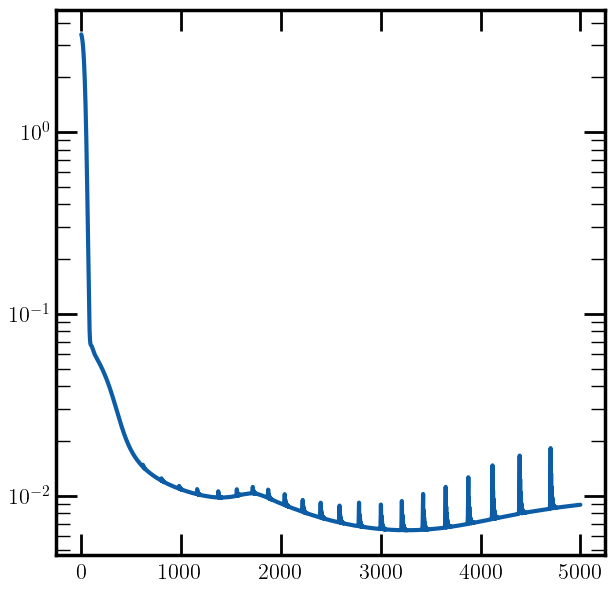

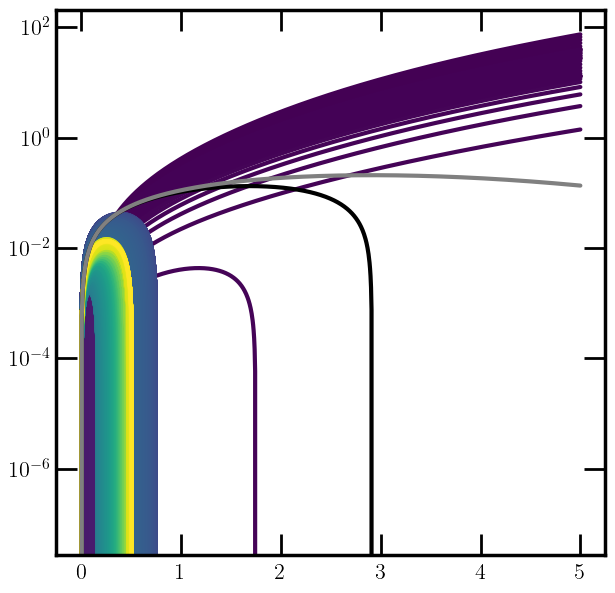

In [17]:
print_polynomial(fprime_coeffs(params, 1, 4, 4))

# Plot loss
fig, ax = newplot("full")
ax.plot(loss_history)
plt.yscale("log")

fig, ax = newplot("full")
# plot the polynomial corresponding to the parameters history
for i, params in enumerate(params_history):
    coeffs = fprime_coeffs(params, 1, 2, 4)
    ts = jnp.linspace(0, 5, 1000)
    vmapped_polynomial = jax.vmap(polynomial, in_axes=(0, None, None))
    ys = vmapped_polynomial(ts, 0.118, coeffs)
    ax.plot(ts, ys, color = plt.cm.viridis(i/len(params_history)))
ax.plot(ts, p_t(ts, 0.118, None), color = "black")
ax.plot(ts, p_ideal(ts, 0.118, None), color = "grey")
plt.yscale("log")